In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**DATA PREPROCESSING**

In [ ]:
class data_preprocessing:
    def __init__(self):
        self.train_set='/kaggle/input/oral-diseases/TRAIN'
        self.test_set='/kaggle/input/oral-diseases/TEST'
        self.basic_transforms=transforms.Compose([
    transforms.RandomRotation(degrees=15),          # Random rotation
    transforms.RandomHorizontalFlip(p=0.5),         # Horizontal flip
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Random crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Gaussian blur
    transforms.ToTensor(),                          # Convert to PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])     # Normalize
])
    def load_datasets(self,path):
        return datasets.ImageFolder(path, transform=self.basic_transforms)
    def dataset_loader(self, dataset):
        return DataLoader(dataset, batch_size=32, shuffle=True)

preprocess=data_preprocessing()
train_dataset=preprocess.load_datasets(preprocess.train_set)
test_dataset=preprocess.load_datasets(preprocess.test_set)
train_loader=preprocess.dataset_loader(train_dataset)
test_loader=preprocess.dataset_loader(test_dataset)

In [ ]:
# Mapping of class indices to folder names
class_names = train_dataset.classes
print("Class Names:", class_names)
print("Class Indices:", train_dataset.class_to_idx)

Class Names: ['Caries', 'Gingivitis']
Class Indices: {'Caries': 0, 'Gingivitis': 1}


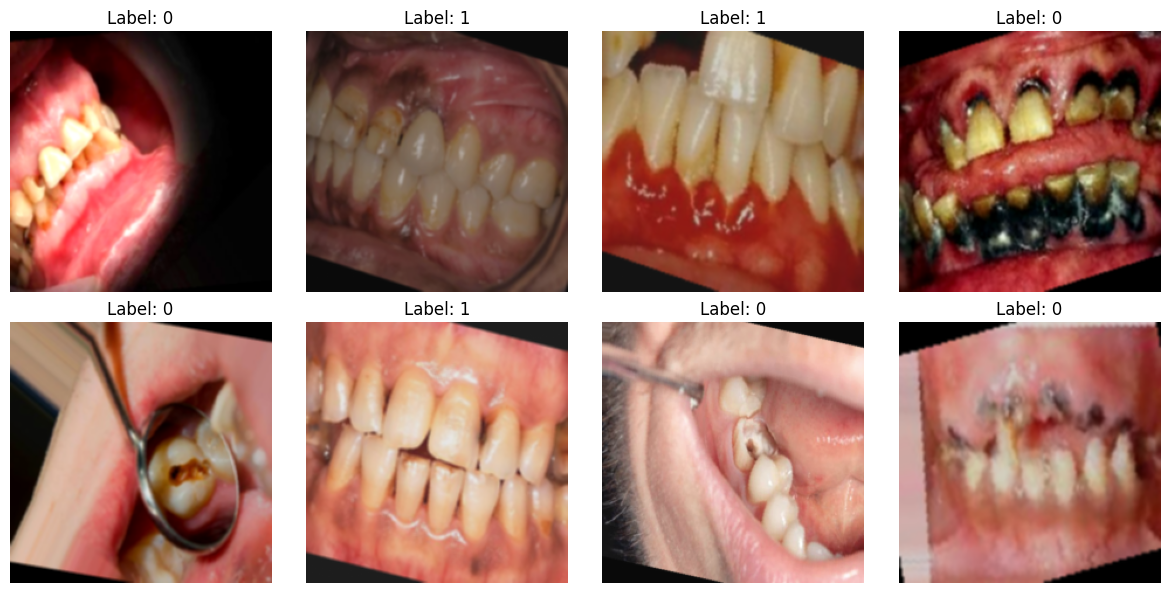

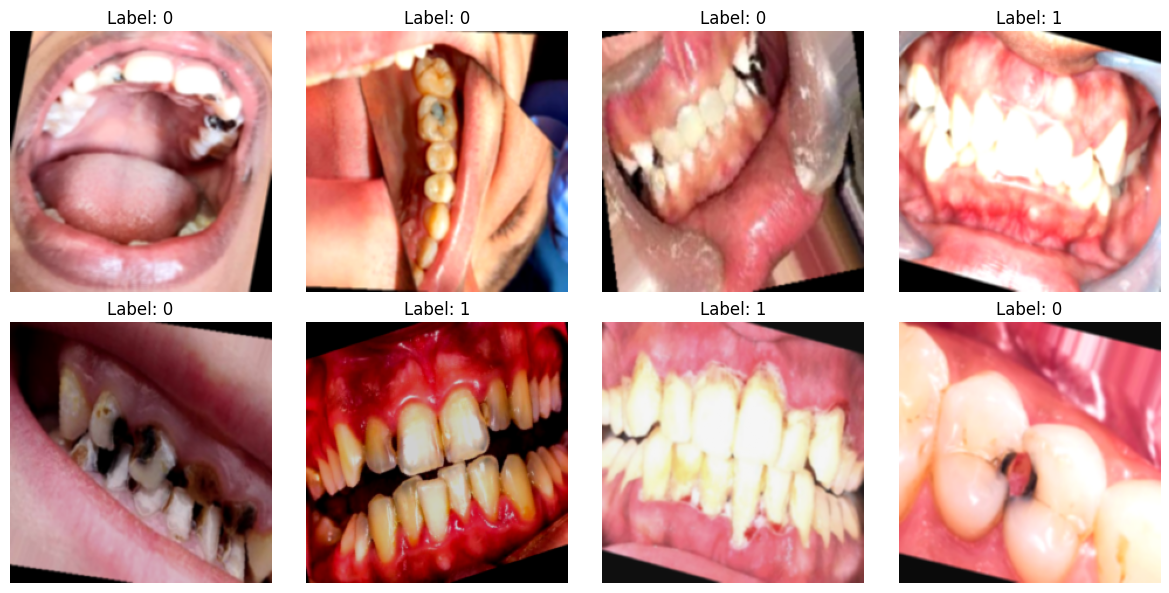

In [ ]:
def visualize_images(loader):
    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Plot images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.permute(1, 2, 0)  # Convert from CHW to HWC
        ax.imshow(img.numpy() * 0.5 + 0.5)  # De-normalize and plot
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_images(test_loader)
visualize_images(train_loader)

**MODEL DEVELOPMENT**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv=nn.Conv2d(2,1,kernel_size=7,padding=3,bias=False)
        self.sigmoid=nn.Sigmoid()
    def forward(self,features):
        average=torch.mean(features,dim=1,keepdim=True)
        max_out,_=torch.max(features, dim=1, keepdim=True)
        attention=torch.cat([average, max_out],dim=1)
        attention=self.sigmoid(self.conv(attention))
        return (features*attention)

class custom_RCNN(nn.Module):
    def __init__(self,num_classes):
        super(custom_RCNN,self).__init__()
        self.feature_extractor=nn.Sequential(nn.Conv2d(3,64,kernel_size=3,padding=1),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.MaxPool2d(2,2),
                                            nn.Conv2d(64,128,kernel_size=3,padding=1),
                                            nn.ReLU(),
                                            nn.Dropout(0.3),
                                            nn.MaxPool2d(2,2))
        self.spatial_attention=SpatialAttention()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes) #These produces the final logits
        )

    def forward(self, x):
        Features = self.feature_extractor(x)
        Features = self.spatial_attention(Features)
        Features = Features.view(Features.size(0), -1)
        logits = self.classifier(Features)
        probs=F.softmax(logits,dim=1)
        return probs

In [ ]:
from torch.utils.data import random_split
# Split test dataset into validation and test sets
val_size = int(0.2 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes
num_classes = 2

In [ ]:
model=custom_RCNN(num_classes=num_classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# class_weights = torch.tensor([1.0, 2.0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #Reducing LR on plateaus

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss

In [ ]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_model_wts = model.state_dict()
    best_acc = 0.0

    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pth')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # train_loss = train_loss / len(train_loader.dataset)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        # Learning rate adjustment
        scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects=0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # val_loss = val_loss / len(val_loader.dataset)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        # print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
        # Deep copy the model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = model.state_dict()

    # Load the best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        # Learning rate adjustment
        scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects.double() / len(train_loader.dataset)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Deep copy the model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    return model

In [ ]:
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

Epoch 1/30
----------
Train Loss: 1209.5067, Val Loss: 69.3742
Validation loss decreased (inf --> 69.374194). Saving model...
Train Loss: 0.8139 Acc: 0.4993
Val Loss: 0.8565 Acc: 0.4568
Epoch 2/30
----------
Train Loss: 1209.5067, Val Loss: 69.3742
Validation loss decreased (69.374194 --> 69.374194). Saving model...
Train Loss: 0.8139 Acc: 0.4993
Val Loss: 0.8565 Acc: 0.4568
Epoch 3/30
----------
Train Loss: 1209.5058, Val Loss: 69.3680
Validation loss decreased (69.374194 --> 69.367960). Saving model...
Train Loss: 0.8139 Acc: 0.4993
Val Loss: 0.8564 Acc: 0.4568
Epoch 4/30
----------
Train Loss: 941.7968, Val Loss: 40.3941
Validation loss decreased (69.367960 --> 40.394060). Saving model...
Train Loss: 0.6338 Acc: 0.6433
Val Loss: 0.4987 Acc: 0.8148
Epoch 5/30
----------
Train Loss: 705.7774, Val Loss: 39.8289
Validation loss decreased (40.394060 --> 39.828939). Saving model...
Train Loss: 0.4750 Acc: 0.8291
Val Loss: 0.4917 Acc: 0.8148
Epoch 6/30
----------
Train Loss: 676.9809, Val 

<ipython-input-35-c16d6a2feea7>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


custom_RCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spatial_attention): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
def evaluate_model_performance(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Classification Report:\n", report)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm


In [ ]:
torch.save(model.state_dict(), "region_guided_cnn_with_attention.pth")


In [ ]:
model.load_state_dict(torch.load("region_guided_cnn_with_attention.pth"))
model.to(device)

<ipython-input-39-7b78082d663b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("region_guided_cnn_with_attention.pth"))


custom_RCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spatial_attention): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

Classification Report:
               precision    recall  f1-score   support

      Caries     0.8409    0.9250    0.8810       160
  Gingivitis     0.9205    0.8323    0.8742       167

    accuracy                         0.8777       327
   macro avg     0.8807    0.8787    0.8776       327
weighted avg     0.8816    0.8777    0.8775       327



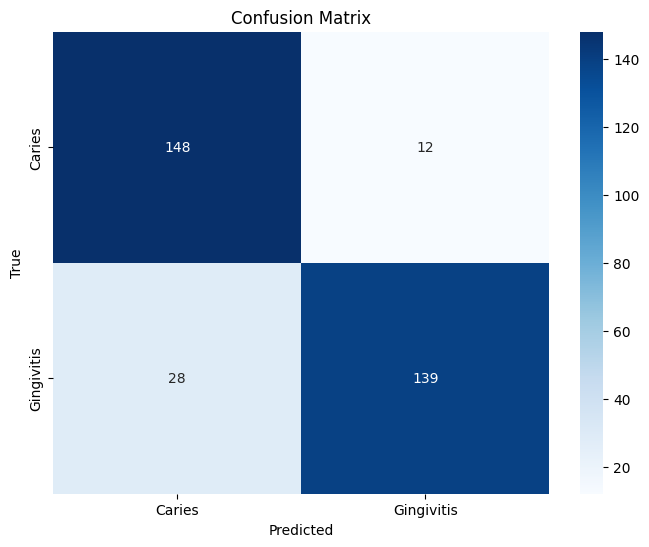

In [ ]:
report, cm = evaluate_model_performance(model, test_loader, class_names)
